# Model Development
- Design a Neural Network for sentence similarity measurement.
- Experiment with different architectures (e.g., transformers, LSTMs).

## Requirements 

In [80]:
# pip install tensorflow_text

In [81]:
# pip install "numpy<2.0.0"

In [82]:
# pip install tensorflow_datasets

In [83]:
# pip install pandas

In [84]:
# pip install matplotlib

In [105]:
# import statements
import logging
import time
import numpy as np
import pandas as pd
import tensorflow_text
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
logging.getLogger('tensorflow').setLevel(logging.ERROR) # suppress warnings

## Loading the data and do train/test split 

In [86]:
# read CSV file 
df = pd.read_csv('/Users/dionnespaltman/Desktop/Luiss/Machine Learning/Project/stopword_removal_dataframe.csv')

# display the first few rows of the dataframe
display(df)

,sentence1,sentence2,score,lang1,lang2,processed_language1,processed_language2
0,ein flugzeug hebt gerade ab,an air plane is taking off,5.0,de,en,Flugzeug heben,air plane
1,ein flugzeug hebt gerade ab,un avión está despegando,5.0,de,es,Flugzeug heben,avión despegar
2,ein flugzeug hebt gerade ab,un avion est en train de décoller,5.0,de,fr,Flugzeug heben,avion train décoller
3,ein flugzeug hebt gerade ab,un aereo sta decollando,5.0,de,it,Flugzeug heben,aereo stare decollare
4,ein flugzeug hebt gerade ab,飛行機が離陸します,5.0,de,ja,Flugzeug heben,飛行機 離陸
...,...,...,...,...,...,...,...
949075,韩国宣布mers疫情结束,北朝鮮の代表団が韓国政府関係者と会談,0.0,zh,ja,韩国 宣布 mers 疫情 结束,北朝鮮 代表団 韓国 政府 関係者 会談
949076,韩国宣布mers疫情结束,delegatie noordkorea ontmoetingen met zuidkore...,0.0,zh,nl,韩国 宣布 mers 疫情 结束,delegatie noordkorea ontmoetingen zuidkoreaans...
949077,韩国宣布mers疫情结束,delegacja korei północnej spotyka się z urzędn...,0.0,zh,pl,韩国 宣布 mers 疫情 结束,delegacja korea północny spotykać urzędnik kor...
949078,韩国宣布mers疫情结束,delegação da coreia do norte reúnese com funci...,0.0,zh,pt,韩国 宣布 mers 疫情 结束,delegação coreia norte reúnese funcionário sul...


In [106]:
# Convert the filtered dataframe to two lists
input_texts = df['processed_language1'].tolist()
target_texts = df['processed_language2'].tolist()

print(type(input_texts), type(target_texts))         # should both be <class 'list'>
print(type(input_texts[0]), type(target_texts[0]))   # should both be <class 'str'>

# Ensure all elements in input_texts and target_texts are strings
input_texts = [str(text) for text in input_texts]
target_texts = [str(text) for text in target_texts]

# Create the TensorFlow dataset
dataset = tf.data.Dataset.from_tensor_slices((input_texts, target_texts))

# Define split ratio
split_ratio = 0.8
total_size = len(input_texts)
train_size = int(total_size * split_ratio)

# Create train and validation datasets
train_examples = dataset.take(train_size)
val_examples = dataset.skip(train_size)

train_examples = train_examples.repeat()


<class 'list'> <class 'list'>
<class 'str'> <class 'str'>


## Build and apply tokenizer

In [ ]:
# Build tokenizers from my text
input_tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    (text for text in input_texts), target_vocab_size=2**13)

target_tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    (text for text in target_texts), target_vocab_size=2**13)


In [89]:
input_tokenizer.save_to_file('/Users/dionnespaltman/Desktop/Luiss/Machine Learning/Project/tokenizer_input')
target_tokenizer.save_to_file('/Users/dionnespaltman/Desktop/Luiss/Machine Learning/Project/tokenizer_target')

In [90]:
# Function to tokenize input-target pairs
# So it gets the input string and the target string and returns tokenized version 
def encode_pair(input_str, target_str):
    input_tokens = input_tokenizer.encode(input_str.numpy().decode('utf-8'))
    target_tokens = target_tokenizer.encode(target_str.numpy().decode('utf-8'))
    return input_tokens, target_tokens

# Wrap with tf.py_function to use in TensorFlow pipeline
# This lets you use regular Python code (like calling .numpy() and .decode()) inside a TensorFlow data pipeline
def tf_encode(input_str, target_str):
    input_tokens, target_tokens = tf.py_function(encode_pair, [input_str, target_str], [tf.int64, tf.int64])
    return input_tokens, target_tokens

# Map the datasets through the tokenizer
# It applies tf_encode to every pair in the dataset. Now each example in train_dataset is a pair of tokenized sequences
train_dataset = train_examples.map(tf_encode)
val_dataset = val_examples.map(tf_encode)

In [91]:
# Take a small batch (e.g., 3) from the dataset
for src_examples, tgt_examples in train_examples.batch(3).take(1):
    print("> Examples in Source Language:")
    for line in src_examples.numpy():
        print(line.decode('utf-8'))

print("----------------------------------------------")

print("> Examples in Target Language:")
for line in tgt_examples.numpy():
    print(line.decode('utf-8'))

print("----------------------------------------------")

# Tokenize the target examples using your custom tokenizer
encoded = [target_tokenizer.encode(text.numpy().decode('utf-8')) for text in tgt_examples]

# Print tokenized form
for row in encoded:
    print(row)

print("----------------------------------------------")

# Detokenize to confirm it's reversible
decoded = [target_tokenizer.decode(tokens) for tokens in encoded]
for line in decoded:
    print(line)


> Examples in Source Language:
Flugzeug heben
Flugzeug heben
Flugzeug heben
----------------------------------------------
> Examples in Target Language:
air plane
avión despegar
avion train décoller
----------------------------------------------
[4198, 2519]
[5120, 4551, 498, 71]
[1656, 30, 285, 976, 185, 1522]
----------------------------------------------
air plane
avión despegar
avion train décoller


2025-05-07 13:13:41.955773: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Get everything ready 

- Prepare tokenized, batched, and masked data for input into a Transformer model.
- Implement core components of the Transformer: positional encoding and multi-head attention.
- This sits between raw data preprocessing and full model definition.

In [92]:
# DATASET PREPARATION 

# Define constants for dataset preparation
# MAX_TOKENS = 128
# BUFFER_SIZE = 20000  # Size of the buffer for shuffling the dataset.
# BATCH_SIZE = 64  # Number of samples per batch.

# Lower constants for baseline 
MAX_TOKENS = 64
BUFFER_SIZE = 1000  # Size of the buffer for shuffling the dataset.
BATCH_SIZE = 16  # Number of samples per batch.

# Tokenization function
def tokenize_pairs(input_text, target_text):
    """
    Tokenizes both input and target strings using SubwordTextEncoder-like tokenizers.
    Returns int64 token sequences with shape info attached.
    """
    # Encode using SubwordTextEncoder and convert to padded tensors
    input_tokens = tf.py_function(
        lambda x: tf.constant(input_tokenizer.encode(x.numpy().decode('utf-8')), dtype=tf.int64),
        [input_text],
        tf.int64
    )
    target_tokens = tf.py_function(
        lambda x: tf.constant(target_tokenizer.encode(x.numpy().decode('utf-8')), dtype=tf.int64),
        [target_text],
        tf.int64
    )

    # Help TF understand the rank of returned tensors for later batching
    input_tokens.set_shape([None])
    target_tokens.set_shape([None])
    return input_tokens, target_tokens

# Filtering function to exclude long sequences
def filter_max_tokens(input_tensor, target_tensor):
    """
    Filters out input-target pairs where either sequence exceeds MAX_TOKENS.
    """
    num_tokens = tf.maximum(tf.shape(input_tensor)[0], tf.shape(target_tensor)[0])
    return num_tokens < MAX_TOKENS

# Batching and preprocessing wrapper
def make_batches(ds):    
    """
    Caches, shuffles, tokenizes, filters, pads, and batches the dataset.
    """
    return (
        ds
        .cache()
        .shuffle(BUFFER_SIZE)
        .map(tokenize_pairs, num_parallel_calls=tf.data.AUTOTUNE)
        .filter(filter_max_tokens)
        .padded_batch(BATCH_SIZE, padded_shapes=([None], [None]))  # pad manually here
        # .repeat() # NEW ADDITION
        .prefetch(tf.data.AUTOTUNE)
    )

# Prepare the training and validation datasets by applying the make_batches function.
train_batches = make_batches(train_examples)
val_batches = make_batches(val_examples)


In [93]:
# POSITIONAL ENCODING 
# Transformers have no recurrence or convolution, so we inject sequence order using sine/cosine signals.

def get_angles(pos, i, d_model):
    """
    Computes the angle rates for the positional encoding.
    The formula ensures that each dimension of the embedding varies at a different wavelength (some change faster than others).

    Parameters:
    - pos: Position index.
    - i: Dimension index.
    - d_model: Depth of the model (number of dimensions).

    Returns:
    - The angle rates for positional encoding.
    """
    # Calculate the angles based on position and dimension index.
    # This formula helps in varying the wavelength across different dimensions.
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    """
    Generates a positional encoding matrix.

    Parameters:
    - position: The maximum position index.
    - d_model: The depth of the model (number of dimensions).

    Returns:
    - A positional encoding matrix of shape (1, position, d_model).
    """
    # Generate angles based on positions and dimensions.
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)
    # Apply sine to even indices in the angles array (2i).
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    # Apply cosine to odd indices in the angles array (2i+1).
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    # Expand the dimensions to fit the model requirements.
    pos_encoding = angle_rads[np.newaxis, ...]
    # Cast the encoding to TensorFlow float32 type.
    return tf.cast(pos_encoding, dtype=tf.float32)


In [94]:
# MASKING 
# Masks prevent attention to padding tokens or future tokens during decoding.

def create_padding_mask(seq):
    """
    Creates a padding mask for sequences.
    This mask hides the padding tokens (i.e., zeros) so they don't affect the attention mechanism. It returns 1s where padding exists, and 0s elsewhere.
    Parameters:
    - seq: The sequence of tokens.

    Returns:
    - A padding mask for the sequence.
    """
    # Create a mask where every zero in the sequence is marked with a 1 (padding) and others with a 0.
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    # Add extra dimensions to the mask so it can be added to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :]  # Shape: (batch_size, 1, 1, seq_len)

def create_look_ahead_mask(size):
    """
    Creates a look-ahead mask to mask future tokens in a sequence.
    Each token can only see previous ones (or itself), but not the next ones, ensuring proper autoregressive behavior.
    Parameters:
    - size: Size of the mask.

    Returns:
    - A look-ahead mask of shape (size, size).
    """
    # Create a mask where every entry that is in the lower triangle (including the diagonal) is 0, and everything else is 1.
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # Shape: (seq_len, seq_len)


In [95]:
# SCALING AND DOT PRODUCT ATTENTION
# This is the core building block of attention: compare queries with keys, weigh values

def scaled_dot_product_attention(q, k, v, mask=None):
    """
    Calculates the attention weights and applies them to the value vectors.

    Parameters:
    - q (query): Tensor with shape (..., seq_len_q, depth)
    - k (key): Tensor with shape (..., seq_len_k, depth)
    - v (value): Tensor with shape (..., seq_len_v, depth_v)
    - mask: (Optional) Float tensor with shape broadcastable to (..., seq_len_q, seq_len_k).

    Returns:
    - output: The result of applying attention weights to the value vectors.
    - attention_weights: The attention weights.
    """
    # Compute the dot product of the query and key tensors. Transpose the key tensor for proper alignment.
    # This gives us a similarity score between each query and key.
    matmul_qk = tf.matmul(q, k, transpose_b=True)  # Shape: (..., seq_len_q, seq_len_k)

    # Scale the dot product by the square root of the depth of the key tensor.
    # This helps in preventing the softmax function from having extremely small gradients.
    dk = tf.cast(tf.shape(k)[-1], tf.float32)  # Get the depth of the keys.
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # Apply the mask if provided. The mask is used to nullify the effect of padding or future information.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  # Use a large negative number to mask.

    # Apply softmax to get the attention weights. The softmax is applied on the key sequence dimension.
    # It shows how much attention each word pays to others.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # Shape: (..., seq_len_q, seq_len_k)

    # Apply the attention weights to the value tensor to get the output.
    output = tf.matmul(attention_weights, v)  # Shape: (..., seq_len_q, depth_v)

    return output, attention_weights



In [96]:
# MULTIHEAD ATTENTION 
# Instead of attending once, we split into multiple attention "heads" for richer representations

class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, *, d_model, num_heads):
        """
        Initialize the MultiHeadAttention layer.

        Parameters:
        - d_model: Dimensionality of the model's output space.
        - num_heads: Number of attention heads.
        """
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads  # Number of attention heads.
        self.d_model = d_model  # Dimensionality of the model's output space.

        # Ensure the model's dimension is divisible by the number of heads to evenly distribute dimensions to each head.
        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads  # Dimensionality per attention head.

        # Define dense layers for the queries, keys, and values.
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        # Final dense layer.
        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        """
        Split the last dimension into (num_heads, depth) and transpose the result.

        Parameters:
        - x: Input tensor.
        - batch_size: Size of the batch.

        Returns:
        - Tensor with shape (batch_size, num_heads, seq_len, depth).
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        """
        The logic for the multi-head attention layer's forward pass.

        Parameters:
        - v: Value tensor.
        - k: Key tensor.
        - q: Query tensor.
        - mask: Mask to be applied.

        Returns:
        - output: Output tensor.
        - attention_weights: Attention weights.
        """
        batch_size = tf.shape(q)[0]

        # Apply dense layers to queries, keys, and values.
        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        # Split the dense outputs into multiple heads and transpose.
        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # Perform scaled dot product attention.
        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)

        # Transpose and reshape the attention output to match the input's dimensionality.
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        # Apply the final dense layer.
        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

        return output, attention_weights
    

In [97]:
def point_wise_feed_forward_network(d_model, dff):
    """
    Creates a point-wise feed forward network. This consists of two dense layers with a ReLU activation
    in between, which is used within each transformer block.

    Parameters:
    - d_model: The dimensionality of the input and output of the transformer model.
    - dff: The dimensionality of the inner layer, typically much larger than d_model to allow
           the model to combine features in the data in a high-dimensional space before projecting
           back down to d_model dimensions.

    Returns:
    - A tf.keras.Sequential model representing the feed forward network.
    """
    return tf.keras.Sequential([
        # First dense layer with dff units and ReLU activation. This expands the dimensionality to dff,
        # allowing the network to learn more complex features.
        tf.keras.layers.Dense(dff, activation='relu'),  # Output shape: (batch_size, seq_len, dff)

        # Second dense layer that projects the outputs back down to d_model dimensions.
        tf.keras.layers.Dense(d_model)  # Output shape: (batch_size, seq_len, d_model)
    ])

## Encoder and decoder layer
We're now implementing the core building block of the Transformer encoder — the EncoderLayer. This is one layer in the stacked encoder block of the Transformer architecture.

High-Level Role of EncoderLayer is: 
- Each encoder layer transforms an input sequence into a richer representation, by letting each token attend to all others (via self-attention);
- Then refining that with a feed-forward network;
- You’ll stack multiple of these layers to form the full encoder (e.g., num_layers = 6).


The EncoderLayer **combines**:

* Multi-Head Self-Attention

* Feed Forward Network

* Layer Normalization

* Dropout

* Residual Connections

Each EncoderLayer **learns** to:

* Focus on different parts of the input through self-attention.

* Extract features and relationships (such as distances) between words.

* Stabilize training using layer normalization and residual connections.*κείμενο σε πλάγια γραφή*

In [98]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, *, d_model, num_heads, dff, rate=0.1):
        """
        Initializes the EncoderLayer with multi-head attention, point-wise feed-forward network,
        dropout, and layer normalization components.

        Parameters:
        - d_model: Dimensionality of the model's output space.
        - num_heads: Number of attention heads.
        - dff: Dimensionality of the feed-forward network's inner layer.
        - rate: Dropout rate.
        """
        super(EncoderLayer, self).__init__()
        self.mha = MultiHeadAttention(d_model=d_model, num_heads=num_heads)  # Multi-head attention layer.
        self.ffn = point_wise_feed_forward_network(d_model, dff)  # Point-wise feed-forward network.

        # Layer normalization (first instance).
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        # Layer normalization (second instance).
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        # Dropout (first instance).
        self.dropout1 = tf.keras.layers.Dropout(rate)
        # Dropout (second instance).
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):
        """
        The logic for one pass of the encoder layer.

        Parameters:
        - x: Input tensor.
        - training: Boolean indicating if the layer should behave in training mode (applying dropout) or in inference mode.
        - mask: Mask to be applied on the multi-head attention layer.

        Returns:
        - The output tensor of the encoder layer.
        """
        # Apply multi-head attention to the input (self attention).
        attn_output, _ = self.mha(x, x, x, mask)  # Output shape: (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)  # Apply dropout to the attention output.

        # Add & normalize.
        out1 = self.layernorm1(x + attn_output)  # Residual connection followed by layer normalization.

        # Apply the feed-forward network to the normalized attention output.
        ffn_output = self.ffn(out1)  # Output shape: (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)  # Apply dropout to the feed-forward network output.

        # Final add & normalize step.
        out2 = self.layernorm2(out1 + ffn_output)  # Residual connection followed by another layer normalization.

        return out2

Each DecoderLayer **learns** to:
* Attend to previous tokens in the target sequence using self-attention, while respecting autoregressive ordering with a look-ahead mask.

* Focus on relevant parts of the input (encoder output) via encoder-decoder attention, aligning source and target information.

* Transform the combined context with a feed-forward network, learning richer representations.

* Stabilize training using dropout, layer normalization, and residual connections throughout.

In [99]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, *, d_model, num_heads, dff, rate=0.1):
        """
        Initializes the DecoderLayer with two multi-head attention mechanisms, a point-wise feed-forward network,
        dropout, and layer normalization components.

        Parameters:
        - d_model: Dimensionality of the model's output space.
        - num_heads: Number of attention heads.
        - dff: Dimensionality of the feed-forward network's inner layer.
        - rate: Dropout rate.
        """
        super(DecoderLayer, self).__init__()
        # First multi-head attention layer (self-attention).
        self.mha1 = MultiHeadAttention(d_model=d_model, num_heads=num_heads)

        # Second multi-head attention layer (encoder-decoder attention).
        self.mha2 = MultiHeadAttention(d_model=d_model, num_heads=num_heads)

        # Point-wise feed-forward network.
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        # Layer normalization (first instance).
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        # Layer normalization (second instance).
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        # Layer normalization (third instance).
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        # Dropout (first instance).
        self.dropout1 = tf.keras.layers.Dropout(rate)
        # Dropout (second instance).
        self.dropout2 = tf.keras.layers.Dropout(rate)
        # Dropout (third instance).
        self.dropout3 = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, *, training, look_ahead_mask, padding_mask):
        """
        The logic for one pass of the decoder layer.

        Parameters:
        - x: Input tensor (target sequence).
        - enc_output: Output tensor from the encoder.
        - training: Boolean indicating if the layer should behave in training mode or inference mode.
        - look_ahead_mask: Mask to prevent the decoder from 'seeing' future tokens.
        - padding_mask: Mask to exclude the attention on padding tokens.

        Returns:
        - The output tensor of the decoder layer.
        - attn_weights_block1: Attention weights from the first multi-head attention layer.
        - attn_weights_block2: Attention weights from the second multi-head attention layer.
        """
        # Apply the first multi-head attention layer (self attention).
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)  # Apply residual connection and layer normalization.

        # Apply the second multi-head attention layer (encoder-decoder attention).
        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)  # Apply residual connection and layer normalization.

        # Apply the feed-forward network.
        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)  # Apply residual connection and layer normalization.

        return out3, attn_weights_block1, attn_weights_block2

## Encoder and decoder

In [100]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, *, num_layers, d_model, num_heads, dff, input_vocab_size, rate=0.1):
        """
        Initializes the Encoder part of the Transformer.

        Parameters:
        - num_layers: Number of encoder layers.
        - d_model: Dimensionality of the model's output space.
        - num_heads: Number of attention heads.
        - dff: Dimensionality of the feed-forward network's inner layer.
        - input_vocab_size: Size of the input vocabulary.
        - rate: Dropout rate.
        """
        super(Encoder, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers

        # Embedding layer for the input tokens.
        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)

        # Positional encoding up to MAX_TOKENS.
        self.pos_encoding = positional_encoding(MAX_TOKENS, self.d_model)

        # Encoder layers
        self.enc_layers = [EncoderLayer(d_model=d_model, num_heads=num_heads, dff=dff, rate=rate) for _ in range(num_layers)]

        # Dropout layer.
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]

        # Adding embedding and position encoding.
        x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))  # Scale embeddings.
        x += self.pos_encoding[:, :seq_len, :]  # Add position encoding.
        x = self.dropout(x, training=training)  # Apply dropout.

        # Pass the input through each encoder layer.
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training=training, mask=mask)


        return x  # (batch_size, input_seq_len, d_model)

In [101]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, *, num_layers, d_model, num_heads, dff, target_vocab_size, rate=0.1):
        """
        Initializes the Decoder part of the Transformer.

        Parameters:
        - num_layers: Number of decoder layers.
        - d_model: Dimensionality of the model's output space.
        - num_heads: Number of attention heads.
        - dff: Dimensionality of the feed-forward network's inner layer.
        - target_vocab_size: Size of the target vocabulary.
        - rate: Dropout rate.
        """
        super(Decoder, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers

        # Embedding layer for the input tokens.
        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)

        # Positional encoding up to MAX_TOKENS.
        self.pos_encoding = positional_encoding(MAX_TOKENS, self.d_model)

        # Decoder layers
        self.dec_layers = [DecoderLayer(d_model=d_model, num_heads=num_heads, dff=dff, rate=rate) for _ in range(num_layers)]

        # Dropout layer.
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}

        # Adding embedding and position encoding.
        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))  # Scale embeddings.
        x += self.pos_encoding[:, :seq_len, :]  # Add position encoding.
        x = self.dropout(x, training=training)  # Apply dropout.

        # Pass the input through each decoder layer.
        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](
                x,
                enc_output,
                training=training,
                look_ahead_mask=look_ahead_mask,
                padding_mask=padding_mask)
            attention_weights[f'decoder_layer{i+1}_block1'] = block1
            attention_weights[f'decoder_layer{i+1}_block2'] = block2

        return x, attention_weights  # (batch_size, target_seq_len, d_model), attention weights

## Transformer

In [102]:
class Transformer(tf.keras.Model):
    def __init__(self, *, num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size, rate=0.1):
        """
        Initializes the Transformer model.

        Parameters:
        - num_layers: Number of layers in both the encoder and decoder.
        - d_model: Dimensionality of the model's output space.
        - num_heads: Number of attention heads.
        - dff: Dimensionality of the feed-forward network's inner layer.
        - input_vocab_size: Size of the input vocabulary.
        - target_vocab_size: Size of the target vocabulary.
        - rate: Dropout rate.
        """
        super().__init__()
        self.encoder = Encoder(num_layers=num_layers, d_model=d_model, num_heads=num_heads, dff=dff, input_vocab_size=input_vocab_size, rate=rate)
        self.decoder = Decoder(num_layers=num_layers, d_model=d_model, num_heads=num_heads, dff=dff, target_vocab_size=target_vocab_size, rate=rate)

        # Final linear layer that projects the decoder's output to the target vocabulary size.
        self.final_layer = tf.keras.layers.Dense(target_vocab_size)

    def call(self, inputs, training):
        """
        The logic for one forward pass through the model.

        Parameters:
        - inputs: A tuple of input tensor and target tensor.
        - training: Boolean indicating if the layer should behave in training mode or inference mode.

        Returns:
        - final_output: The model's output predictions.
        - attention_weights: The attention weights from the decoder.
        """
        inp, tar = inputs

        # Create masks for padding and future tokens.
        enc_padding_mask, look_ahead_mask, dec_padding_mask = self.create_masks(inp, tar)

        # Pass the input through the encoder.
        #enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)
        #self.encoder(inp, training=training, mask=enc_padding_mask)
        enc_output = self.encoder(inp, training=training, mask=enc_padding_mask)

        # Pass the encoder output and target through the decoder.
        #dec_output, attention_weights = self.decoder(tar, enc_output, training, look_ahead_mask, dec_padding_mask)
        #self.decoder(tar, enc_output, training=training,
         #    look_ahead_mask=look_ahead_mask,
          #   padding_mask=dec_padding_mask)

        dec_output, attention_weights = self.decoder(
              tar,
              enc_output,
              training=training,
              look_ahead_mask=look_ahead_mask,
              padding_mask=dec_padding_mask)


        # Pass the decoder output through the final linear layer.
        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

        return final_output, attention_weights

    def create_masks(self, inp, tar):
        """
        Creates masks for padding and look ahead for the encoder and decoder.

        Parameters:
        - inp: Input tensor.
        - tar: Target tensor.

        Returns:
        - enc_padding_mask: Padding mask for the encoder.
        - look_ahead_mask: Look-ahead mask for the decoder.
        - dec_padding_mask: Padding mask for the decoder to mask the encoder outputs.
        """
        # Encoder padding mask.
        enc_padding_mask = create_padding_mask(inp)

        # Decoder padding mask for the second attention block (to mask encoder outputs).
        dec_padding_mask = create_padding_mask(inp)

        # Look-ahead mask (to mask future tokens) and decoder target padding mask combined.
        look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
        dec_target_padding_mask = create_padding_mask(tar)
        look_ahead_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

        return enc_padding_mask, look_ahead_mask, dec_padding_mask
    
# -------------------------------
# Transformer Model Hyperparameters
# -------------------------------

num_layers = 4 # number of encoder/decoder layers in the Transformer
d_model = 128 # size of the embedding vector for each word
dff = 512 # size of the hidden layer inside the Feed Forward Neural Network
num_heads = 8 # number of attention heads (must divide d_model evenly)
dropout_rate = 0.1 # dropout rate for regularization

class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)  # Model dimensionality, cast to float32 for calculation.
        self.warmup_steps = warmup_steps  # Number of steps to linearly increase the learning rate.

    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)  # Linearly increase then decrease based on warmup steps.
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)  # Calculate the learning rate.
        # Final learning rate: (1 / sqrt(d_model)) * min(arg1, arg2)

# Instantiate the learning rate schedule and Adam optimizer
learning_rate = CustomSchedule(d_model)
optimizer = tf.keras.optimizers.Adam(
    learning_rate,
    beta_1=0.9,         # First moment decay (default)
    beta_2=0.98,        # Second moment decay (used in the original Transformer paper)
    epsilon=1e-9        # Small value to avoid division by zero
)

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))  # Create a mask for non-zero tokens.
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
    loss_ = loss_object(real, pred)  # Calculate loss using some loss object not defined here.
    mask = tf.cast(mask, dtype=loss_.dtype)  # Cast mask to the same type as the loss.
    loss_ *= mask  # Apply mask to the loss.
    return tf.reduce_sum(loss_) / tf.reduce_sum(mask)  # Calculate the average loss.

def accuracy_function(real, pred):
    accuracies = tf.equal(real, tf.argmax(pred, axis=2))  # Check if real values match predictions.
    mask = tf.math.logical_not(tf.math.equal(real, 0))  # Create a mask for non-zero tokens.
    accuracies = tf.math.logical_and(mask, accuracies)  # Apply mask to accuracies.
    accuracies = tf.cast(accuracies, dtype=tf.float32)  # Cast to float32 for calculation.
    mask = tf.cast(mask, dtype=tf.float32)  # Cast mask to float32.
    return tf.reduce_sum(accuracies) / tf.reduce_sum(mask)  # Calculate the average accuracy.


train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

In [103]:
# -------------------------------
# Instantiate the Transformer model
# -------------------------------
transformer = Transformer(
    num_layers=num_layers,                        # Number of encoder and decoder layers
    d_model=d_model,                              # Embedding size / model dimensionality
    num_heads=num_heads,                          # Number of attention heads
    dff=dff,                                      # Hidden layer size in feed-forward network
    input_vocab_size = input_tokenizer.vocab_size,
    target_vocab_size = target_tokenizer.vocab_size,
    rate=dropout_rate                             # Dropout rate
)

# -------------------------------
# Checkpointing: Saving and restoring model state
# -------------------------------

checkpoint_path = './checkpoints/train'   # Directory to save training checkpoints

# Create a checkpoint object that tracks the transformer and optimizer state
ckpt = tf.train.Checkpoint(transformer=transformer, optimizer=optimizer)

# Manage multiple checkpoints (e.g., keep the 5 latest ones)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# If a previous checkpoint exists, restore the model and optimizer state
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print('Latest checkpoint restored!!')

# -------------------------------
# Define input signature for tf.function (for performance optimization)
# Used to decorate the training step function later
# -------------------------------
train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),  # Input sequence shape: (batch_size, input_seq_len)
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),  # Target sequence shape: (batch_size, target_seq_len)
]


## Baseline 



In [104]:
@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
    """
    Performs a single training step for the Transformer model.

    Args:
    inp: Input sequence batch (Portuguese).
    tar: Target sequence batch (English).

    The target sequence is split into decoder inputs (`tar_inp`) and the real outputs (`tar_real`).
    The model makes predictions for `tar_inp` and is trained against `tar_real`.
    """
    # Prepare target inputs and outputs
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    with tf.GradientTape() as tape:
        predictions, _ = transformer([inp, tar_inp], training=True)
        loss = loss_function(tar_real, predictions)

    # Compute gradients and apply them
    gradients = tape.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    # Update the training loss and accuracy metrics
    train_loss(loss)
    train_accuracy(accuracy_function(tar_real, predictions))

    return loss, predictions

epoch_losses = []
epoch_accuracies = []

all_batch_losses = []
all_batch_accuracies = []

EPOCHS = 10
steps_per_epoch = 1000  # Set based on dataset size / batch size

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch + 1} -------------------")
    print("Re-initializing dataset iterator")
    train_iter = iter(train_batches)

    # Peek at 1 batch
    try:
        sample = next(train_iter)
        print("Batch loaded successfully.")
    except Exception as e:
        print("Batch loading failed:", e)

    
    start = time.time()

    # Recreate infinite train_batches with .repeat()
    train_batches = make_batches(train_examples)
    train_iter = iter(train_batches)

    batch_losses = []
    batch_accuracies = []

    # Reset metrics
    train_loss = tf.keras.metrics.Mean(name='train_loss')
    train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

    # Use fixed number of steps instead of iterating over the whole dataset
    for step in range(steps_per_epoch):
        print("Sample input shape:", inp.shape)
        print("Sample target shape:", tar.shape)

        inp, tar = next(train_iter)
        loss, predictions = train_step(inp, tar)

        batch_losses.append(loss.numpy())
        batch_accuracies.append(accuracy_function(tar[:, 1:], predictions).numpy())

        if step % 50 == 0:
            print(f'Epoch {epoch + 1} Step {step} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

    all_batch_losses.append(batch_losses)
    all_batch_accuracies.append(batch_accuracies)
    epoch_losses.append(train_loss.result().numpy())
    epoch_accuracies.append(train_accuracy.result().numpy())

    if (epoch + 1) % 3 == 0:
        ckpt_save_path = ckpt_manager.save()
        print(f'Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}')

    print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')
    print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')



Epoch 1 -------------------
Re-initializing dataset iterator


2025-05-07 13:13:42.530776: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Batch loaded successfully.


2025-05-07 13:13:43.020118: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Sample input shape: (16, 16)
Sample target shape: (16, 18)
Epoch 1 Step 0 Loss 9.0115 Accuracy 0.0000
Sample input shape: (16, 21)
Sample target shape: (16, 32)
Sample input shape: (16, 10)
Sample target shape: (16, 32)
Sample input shape: (16, 27)
Sample target shape: (16, 15)
Sample input shape: (16, 13)
Sample target shape: (16, 16)
Sample input shape: (16, 12)
Sample target shape: (16, 14)
Sample input shape: (16, 13)
Sample target shape: (16, 32)
Sample input shape: (16, 21)
Sample target shape: (16, 15)
Sample input shape: (16, 11)
Sample target shape: (16, 13)
Sample input shape: (16, 8)
Sample target shape: (16, 14)
Sample input shape: (16, 9)
Sample target shape: (16, 16)
Sample input shape: (16, 12)
Sample target shape: (16, 13)
Sample input shape: (16, 16)
Sample target shape: (16, 9)
Sample input shape: (16, 9)
Sample target shape: (16, 16)
Sample input shape: (16, 16)
Sample target shape: (16, 13)
Sample input shape: (16, 10)
Sample target shape: (16, 16)
Sample input shap

2025-05-07 13:17:30.463753: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-05-07 13:17:30.601287: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 2 Step 0 Loss 0.0000 Accuracy 0.0000
Sample input shape: (16, 21)
Sample target shape: (16, 13)
Sample input shape: (16, 9)
Sample target shape: (16, 14)
Sample input shape: (16, 10)
Sample target shape: (16, 14)
Sample input shape: (16, 11)
Sample target shape: (16, 20)
Sample input shape: (16, 21)
Sample target shape: (16, 32)
Sample input shape: (16, 11)
Sample target shape: (16, 16)
Sample input shape: (16, 11)
Sample target shape: (16, 16)
Sample input shape: (16, 8)
Sample target shape: (16, 14)
Sample input shape: (16, 11)
Sample target shape: (16, 19)
Sample input shape: (16, 16)
Sample target shape: (16, 32)
Sample input shape: (16, 16)
Sample target shape: (16, 16)
Sample input shape: (16, 11)
Sample target shape: (16, 19)
Sample input shape: (16, 13)
Sample target shape: (16, 15)
Sample input shape: (16, 27)
Sample target shape: (16, 20)
Sample input shape: (16, 13)
Sample target shape: (16, 16)
Sample input shape: (16, 16)
Sample target shape: (16, 15)
Sample input sh

2025-05-07 13:20:43.235405: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-05-07 13:20:43.375283: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 3 Step 0 Loss 0.0000 Accuracy 0.0000
Sample input shape: (16, 27)
Sample target shape: (16, 16)
Sample input shape: (16, 11)
Sample target shape: (16, 15)
Sample input shape: (16, 27)
Sample target shape: (16, 20)
Sample input shape: (16, 12)
Sample target shape: (16, 15)
Sample input shape: (16, 12)
Sample target shape: (16, 32)
Sample input shape: (16, 11)
Sample target shape: (16, 20)
Sample input shape: (16, 13)
Sample target shape: (16, 15)
Sample input shape: (16, 11)
Sample target shape: (16, 20)
Sample input shape: (16, 9)
Sample target shape: (16, 20)
Sample input shape: (16, 13)
Sample target shape: (16, 16)
Sample input shape: (16, 13)
Sample target shape: (16, 16)
Sample input shape: (16, 10)
Sample target shape: (16, 15)
Sample input shape: (16, 27)
Sample target shape: (16, 16)
Sample input shape: (16, 9)
Sample target shape: (16, 14)
Sample input shape: (16, 16)
Sample target shape: (16, 13)
Sample input shape: (16, 16)
Sample target shape: (16, 16)
Sample input sh

2025-05-07 13:23:57.526888: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-05-07 13:23:57.682190: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 4 Step 0 Loss 0.0000 Accuracy 0.0000
Sample input shape: (16, 11)
Sample target shape: (16, 16)
Sample input shape: (16, 13)
Sample target shape: (16, 19)
Sample input shape: (16, 21)
Sample target shape: (16, 16)
Sample input shape: (16, 9)
Sample target shape: (16, 9)
Sample input shape: (16, 27)
Sample target shape: (16, 19)
Sample input shape: (16, 21)
Sample target shape: (16, 15)
Sample input shape: (16, 10)
Sample target shape: (16, 32)
Sample input shape: (16, 11)
Sample target shape: (16, 19)
Sample input shape: (16, 11)
Sample target shape: (16, 16)
Sample input shape: (16, 16)
Sample target shape: (16, 14)
Sample input shape: (16, 16)
Sample target shape: (16, 32)
Sample input shape: (16, 12)
Sample target shape: (16, 13)
Sample input shape: (16, 11)
Sample target shape: (16, 13)
Sample input shape: (16, 11)
Sample target shape: (16, 14)
Sample input shape: (16, 9)
Sample target shape: (16, 13)
Sample input shape: (16, 21)
Sample target shape: (16, 15)
Sample input sha

2025-05-07 13:27:14.339803: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-05-07 13:27:14.479807: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 5 Step 0 Loss 0.0000 Accuracy 0.0000
Sample input shape: (16, 13)
Sample target shape: (16, 32)
Sample input shape: (16, 27)
Sample target shape: (16, 16)
Sample input shape: (16, 12)
Sample target shape: (16, 15)
Sample input shape: (16, 12)
Sample target shape: (16, 15)
Sample input shape: (16, 11)
Sample target shape: (16, 20)
Sample input shape: (16, 13)
Sample target shape: (16, 19)
Sample input shape: (16, 12)
Sample target shape: (16, 32)
Sample input shape: (16, 16)
Sample target shape: (16, 12)
Sample input shape: (16, 12)
Sample target shape: (16, 16)
Sample input shape: (16, 27)
Sample target shape: (16, 32)
Sample input shape: (16, 13)
Sample target shape: (16, 32)
Sample input shape: (16, 13)
Sample target shape: (16, 16)
Sample input shape: (16, 8)
Sample target shape: (16, 11)
Sample input shape: (16, 10)
Sample target shape: (16, 16)
Sample input shape: (16, 21)
Sample target shape: (16, 17)
Sample input shape: (16, 16)
Sample target shape: (16, 22)
Sample input s

2025-05-07 13:30:31.285360: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-05-07 13:30:31.425730: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 6 Step 0 Loss 0.0000 Accuracy 0.0000
Sample input shape: (16, 13)
Sample target shape: (16, 15)
Sample input shape: (16, 27)
Sample target shape: (16, 19)
Sample input shape: (16, 27)
Sample target shape: (16, 16)
Sample input shape: (16, 11)
Sample target shape: (16, 19)
Sample input shape: (16, 21)
Sample target shape: (16, 16)
Sample input shape: (16, 13)
Sample target shape: (16, 15)
Sample input shape: (16, 11)
Sample target shape: (16, 13)
Sample input shape: (16, 21)
Sample target shape: (16, 32)
Sample input shape: (16, 13)
Sample target shape: (16, 32)
Sample input shape: (16, 11)
Sample target shape: (16, 16)
Sample input shape: (16, 9)
Sample target shape: (16, 16)
Sample input shape: (16, 11)
Sample target shape: (16, 14)
Sample input shape: (16, 10)
Sample target shape: (16, 16)
Sample input shape: (16, 11)
Sample target shape: (16, 19)
Sample input shape: (16, 10)
Sample target shape: (16, 14)
Sample input shape: (16, 11)
Sample target shape: (16, 16)
Sample input s

2025-05-07 13:33:48.828981: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-05-07 13:33:48.970633: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 7 Step 0 Loss 0.0000 Accuracy 0.0000
Sample input shape: (16, 12)
Sample target shape: (16, 16)
Sample input shape: (16, 27)
Sample target shape: (16, 16)
Sample input shape: (16, 13)
Sample target shape: (16, 16)
Sample input shape: (16, 11)
Sample target shape: (16, 14)
Sample input shape: (16, 12)
Sample target shape: (16, 16)
Sample input shape: (16, 13)
Sample target shape: (16, 19)
Sample input shape: (16, 27)
Sample target shape: (16, 19)
Sample input shape: (16, 11)
Sample target shape: (16, 13)
Sample input shape: (16, 11)
Sample target shape: (16, 19)
Sample input shape: (16, 16)
Sample target shape: (16, 12)
Sample input shape: (16, 16)
Sample target shape: (16, 16)
Sample input shape: (16, 16)
Sample target shape: (16, 16)
Sample input shape: (16, 12)
Sample target shape: (16, 16)
Sample input shape: (16, 21)
Sample target shape: (16, 20)
Sample input shape: (16, 13)
Sample target shape: (16, 16)
Sample input shape: (16, 8)
Sample target shape: (16, 10)
Sample input s

2025-05-07 13:37:04.232708: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-05-07 13:37:04.374416: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Batch loaded successfully.
Sample input shape: (16, 11)
Sample target shape: (16, 9)
Epoch 8 Step 0 Loss 0.0000 Accuracy 0.0000
Sample input shape: (16, 13)
Sample target shape: (16, 32)
Sample input shape: (16, 9)
Sample target shape: (16, 15)
Sample input shape: (16, 21)
Sample target shape: (16, 16)
Sample input shape: (16, 11)
Sample target shape: (16, 16)
Sample input shape: (16, 13)
Sample target shape: (16, 16)
Sample input shape: (16, 9)
Sample target shape: (16, 12)
Sample input shape: (16, 9)
Sample target shape: (16, 20)
Sample input shape: (16, 27)
Sample target shape: (16, 32)
Sample input shape: (16, 16)
Sample target shape: (16, 15)
Sample input shape: (16, 11)
Sample target shape: (16, 16)
Sample input shape: (16, 8)
Sample target shape: (16, 13)
Sample input shape: (16, 27)
Sample target shape: (16, 15)
Sample input shape: (16, 21)
Sample target shape: (16, 16)
Sample input shape: (16, 21)
Sample target shape: (16, 15)
Sample input shape: (16, 16)
Sample target shape: 

2025-05-07 13:40:19.170143: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-05-07 13:40:19.310176: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Batch loaded successfully.
Sample input shape: (16, 11)
Sample target shape: (16, 13)
Epoch 9 Step 0 Loss 0.0000 Accuracy 0.0000
Sample input shape: (16, 8)
Sample target shape: (16, 12)
Sample input shape: (16, 21)
Sample target shape: (16, 32)
Sample input shape: (16, 11)
Sample target shape: (16, 20)
Sample input shape: (16, 11)
Sample target shape: (16, 16)
Sample input shape: (16, 11)
Sample target shape: (16, 32)
Sample input shape: (16, 27)
Sample target shape: (16, 15)
Sample input shape: (16, 9)
Sample target shape: (16, 14)
Sample input shape: (16, 16)
Sample target shape: (16, 32)
Sample input shape: (16, 13)
Sample target shape: (16, 16)
Sample input shape: (16, 27)
Sample target shape: (16, 20)
Sample input shape: (16, 16)
Sample target shape: (16, 16)
Sample input shape: (16, 27)
Sample target shape: (16, 16)
Sample input shape: (16, 12)
Sample target shape: (16, 15)
Sample input shape: (16, 8)
Sample target shape: (16, 14)
Sample input shape: (16, 12)
Sample target shape

2025-05-07 13:43:32.382145: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-05-07 13:43:32.498457: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 10 Step 0 Loss 0.0000 Accuracy 0.0000
Sample input shape: (16, 12)
Sample target shape: (16, 16)
Sample input shape: (16, 13)
Sample target shape: (16, 15)
Sample input shape: (16, 12)
Sample target shape: (16, 32)
Sample input shape: (16, 12)
Sample target shape: (16, 19)
Sample input shape: (16, 21)
Sample target shape: (16, 15)
Sample input shape: (16, 8)
Sample target shape: (16, 14)
Sample input shape: (16, 13)
Sample target shape: (16, 16)
Sample input shape: (16, 13)
Sample target shape: (16, 15)
Sample input shape: (16, 11)
Sample target shape: (16, 32)
Sample input shape: (16, 27)
Sample target shape: (16, 20)
Sample input shape: (16, 12)
Sample target shape: (16, 19)
Sample input shape: (16, 12)
Sample target shape: (16, 14)
Sample input shape: (16, 27)
Sample target shape: (16, 16)
Sample input shape: (16, 13)
Sample target shape: (16, 16)
Sample input shape: (16, 21)
Sample target shape: (16, 16)
Sample input shape: (16, 11)
Sample target shape: (16, 16)
Sample input 

KeyboardInterrupt: 

## Plot

In [ ]:
print(all_batch_losses[0])

[2.5216317, 2.497651, 2.5012555, 2.6325054, 2.6632063, 2.661966, 2.6764028, 2.700579, 2.660774, 2.6506662, 2.6074173, 2.5853543, 2.5780234, 2.5673373, 2.5759957, 2.5639825, 2.5610626, 2.5650063, 2.556825, 2.5494914, 2.5520883, 2.5559332, 2.5581458, 2.5493815, 2.5410933, 2.5325258, 2.5181797, 2.5137405, 2.5353906, 2.5272088, 2.520136, 2.5168388, 2.5171654, 2.516698, 2.5141442, 2.5050988, 2.495182, 2.4960008, 2.4865117, 2.4839835, 2.4795678, 2.473547, 2.4700606, 2.459125, 2.453179, 2.4464798, 2.4354002, 2.4220524, 2.4153426, 2.4080575, 2.4002213, 2.3935106, 2.387281, 2.3778443, 2.3731859, 2.365722, 2.3620217, 2.356491, 2.3513563, 2.3438694, 2.3419497, 2.338674, 2.3382845, 2.3444853, 2.3380568, 2.33459, 2.3296192, 2.3342142, 2.3316605, 2.3285894, 2.3200722, 2.3129592, 2.308533, 2.3029828, 2.2988026, 2.2933838, 2.28864, 2.288671, 2.2861302, 2.2824173, 2.2783587, 2.2766113, 2.2738795, 2.269363, 2.2646961, 2.261054, 2.2565863, 2.255198, 2.2522106, 2.2467105, 2.244049, 2.2412364, 2.239179, 2.

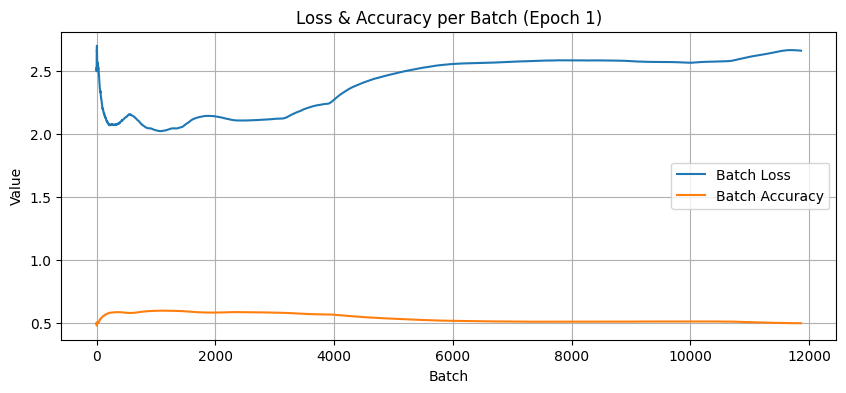

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(all_batch_losses[0], label='Batch Loss')
plt.plot(all_batch_accuracies[0], label='Batch Accuracy')
plt.xlabel('Batch')
plt.ylabel('Value')
plt.title('Loss & Accuracy per Batch (Epoch 1)')
plt.legend()
plt.grid(True)
plt.show()


## Translator

In [ ]:
class Translator(tf.Module):
    def __init__(self, tokenizers, transformer):
        """
        Initializes the Translator module.

        Parameters:
        - tokenizers: A collection containing source (Portuguese) and target (English) tokenizers.
        - transformer: The trained Transformer model for translation.
        """
        self.tokenizers = tokenizers
        self.transformer = transformer

    def __call__(self, sentence, max_length=128):
        """
        Translates a Portuguese sentence to English.

        Parameters:
        - sentence: The input sentence, a tf.Tensor of Portuguese text.
        - max_length: The maximum length of the translated sequence.

        Returns:
        - text: The translated sentence.
        - tokens: The tokenized representation of the translated sentence.
        - attention_weights: The attention weights from the Transformer model.
        """
        assert isinstance(sentence, tf.Tensor), "Input must be a tf.Tensor"
        if len(sentence.shape) == 0:
            sentence = sentence[tf.newaxis]

        # Tokenize the input sentence.
        sentence = self.tokenizers.pt.tokenize(sentence).to_tensor()
        encoder_input = sentence

        # Initialize the output with the English start token.
        start_end = self.tokenizers.en.tokenize([''])[0]
        start, end = start_end[0][tf.newaxis], start_end[1][tf.newaxis]

        output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
        output_array = output_array.write(0, start)

        for i in tf.range(max_length):
            output = tf.transpose(output_array.stack())
            predictions, _ = self.transformer([encoder_input, output], training=False)

            # Select the last token from the predictions.
            predictions = predictions[:, -1:, :]
            predicted_id = tf.argmax(predictions, axis=-1)

            # Concatenate the predicted_id to the output.
            output_array = output_array.write(i+1, predicted_id[0])

            if tf.reduce_all(predicted_id == end):
                break

        output = tf.transpose(output_array.stack())

        # Convert the output tokens to text and lookup the corresponding words.
        text = self.tokenizers.en.detokenize(output)[0]  # Convert tokens to text.
        tokens = self.tokenizers.en.lookup(output)[0]    # Convert tokens to words.

        # Recalculate attention weights with the final output for visualization.
        _, attention_weights = self.transformer([encoder_input, output[:, :-1]], training=False)

        return text, tokens, attention_weights


In [ ]:
# Initialize the translator module with the necessary tokenizers and transformer model.
translator = Translator(tokenizers, transformer)

def print_translation(sentence, translated_text, ground_truth):
    """
    Prints the original sentence, the model's translation, and the ground truth translation.

    Args:
    - sentence: The original sentence (in Portuguese).
    - translated_text: The translated sentence (in English) produced by the model.
    - ground_truth: The actual translation of the sentence (ground truth).
    """
    print(f'{"Input:":15s}: {sentence}')
    print(f'{"Prediction":15s}: {translated_text.numpy().decode("utf-8")}')
    print(f'{"Ground truth":15s}: {ground_truth}')

# The Portuguese sentence to be translated.
sentence = 'os meus vizinhos ouviram sobre esta ideia.'

# The ground truth English translation of the Portuguese sentence.
ground_truth = 'and my neighboring homes heard about this idea .'

# Perform the translation using the `translator` instance.
translated_text, translated_tokens, attention_weights = translator(tf.constant(sentence))

# Print the results.
print_translation(sentence, translated_text, ground_truth)